In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
import seaborn as sns
import fotmob_scraper as fms
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO
from scipy.ndimage import gaussian_filter
# mplsoccer 
from mplsoccer import VerticalPitch, Pitch

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df_teams = pd.read_csv('data/super_leagues_team_stats_2223.csv', index_col=0)
df_games = pd.read_csv('data/super_leagues_game_stats_2223.csv', index_col=0)
df_shots = pd.read_csv('data/super_leagues_shots_2223.csv', index_col=0)

In [3]:
team_colors: dict = {
    'BAS': '#FF1433', 
    'ZUR': '#00BFFF', 
    'GRA': '#0064B9', 
    'LAU': '#006EB7', 
    'LUG': '#000000', 
    'LUZ': '#154281', 
    'SER': '#870E26', 
    'SIO': '#EC1F00', 
    'GAL': '#008141',
    'YB': '#FFD940',
    'WIN':'#AB0707', 
    'AVG': '#FFFFFF'
}

In [4]:
team_logo_url = {
    'YB': "https://images.fotmob.com/image_resources/logo/teamlogo/10192.png", 
    'LUZ': "https://images.fotmob.com/image_resources/logo/teamlogo/10199.png", 
    'GAL': "https://images.fotmob.com/image_resources/logo/teamlogo/10190.png", 
    'LAU': "https://images.fotmob.com/image_resources/logo/teamlogo/7730.png", 
    'LUG': "https://images.fotmob.com/image_resources/logo/teamlogo/7896.png", 
    'ZUR': "https://images.fotmob.com/image_resources/logo/teamlogo/10243.png", 
    'GRA': "https://images.fotmob.com/image_resources/logo/teamlogo/9956.png", 
    'BAS': "https://images.fotmob.com/image_resources/logo/teamlogo/9931.png",
    'SER': "https://images.fotmob.com/image_resources/logo/teamlogo/9777.png",
    'SIO': "https://images.fotmob.com/image_resources/logo/teamlogo/10179.png",
    'WIN': "https://images.fotmob.com/image_resources/logo/teamlogo/7894.png"
    }

In [5]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
team_names = dict(zip(df_teams['team_short'],df_teams['team']))
team_names['BAS'] = 'FC Basel'
team_names['GRA'] = 'Grasshoppers Zürich'
team_names['LUG'] = 'FC Lugano'
team_names['LUZ'] = 'FC Luzern'
team_names['SER'] = 'Servette FC'
team_names['SIO'] = 'FC Sion'
team_names['GAL'] = 'FC St. Gallen'
team_names['YB'] = 'BSC Young Boys'
team_names['WIN'] = 'FC Winterthur'

In [7]:
team_names

{'BAS': 'FC Basel',
 'ZUR': 'FC Zürich',
 'GRA': 'Grasshoppers Zürich',
 'LUG': 'FC Lugano',
 'LUZ': 'FC Luzern',
 'SER': 'Servette FC',
 'SIO': 'FC Sion',
 'GAL': 'FC St. Gallen',
 'WIN': 'FC Winterthur',
 'YB': 'BSC Young Boys'}

## xG rates for the 22/23 season

## xG vs. xGA / per game

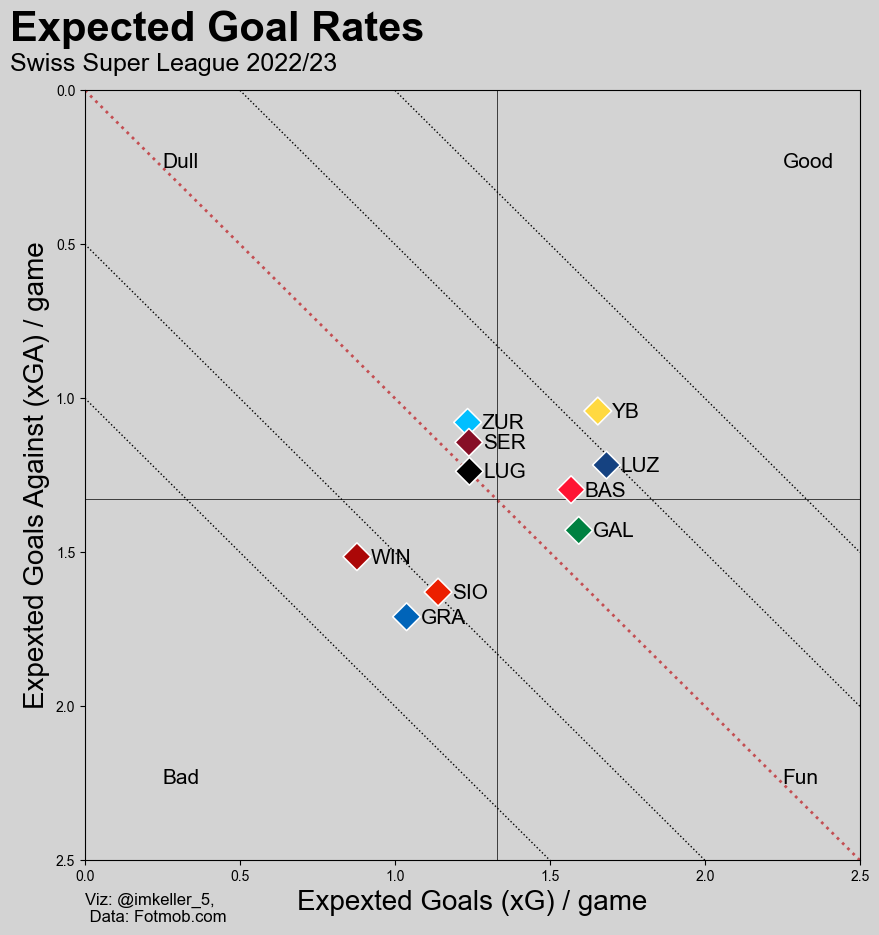

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

sns.set_theme(style="darkgrid")
sns.set_context("paper")

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.axvline(df_teams['expected_goals_against_(xga)_mean'].mean(), color=text_color, linewidth=0.5, zorder=5)
ax.axhline(df_teams['expected_goals_(xg)_mean'].mean(), color=text_color, linewidth=0.5, zorder=0)
sns.scatterplot(x='expected_goals_(xg)_mean', y='expected_goals_against_(xga)_mean',hue='team_short',palette=team_colors,data=df_teams, s=200,legend=False,marker='D',zorder=10)
ax.set_xlabel('Expexted Goals (xG) / game',fontsize=20,color=text_color)
ax.set_ylabel('Expexted Goals Against (xGA) / game',fontsize=20,color=text_color)

fig.text(0.05,0.93,'Expected Goal Rates', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.05,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18,color=text_color)

ax.set_xlim(0,2.5)
ax.set_ylim(0,2.5)

ax.axline(xy1=(0, 0), slope=1, color='r', lw=2,ls='dotted')
ax.axline(xy1=(0.5, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(-0.5, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(1, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(-1, 0), slope=1, color=text_color, lw=1,ls='dotted')

ax.axes.invert_yaxis()

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

for a in df_teams['team_short']:
    ax.annotate(a, (df_teams.loc[df_teams['team_short'] == a,'expected_goals_(xg)_mean'].values[0],df_teams.loc[df_teams['team_short'] == a,'expected_goals_against_(xga)_mean'].values[0]), xytext=(10,-5), textcoords='offset points', fontsize=15,color=text_color, zorder=100)

ax.annotate("Viz: @imkeller_5, \n Data: Fotmob.com", (0, 2.7), annotation_clip=False, fontsize=12,color=text_color)
ax.annotate("Good", (2.25, 0.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Dull", (0.25, 0.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Bad", (0.25, 2.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Fun", (2.25, 2.25), annotation_clip=False, fontsize=15,color=text_color)

plt.show()

fig.savefig('figs/super_league_xg_rates_23_01_28.jpg',bbox_inches='tight')

##  Goals over expected vs. Goals against over expected

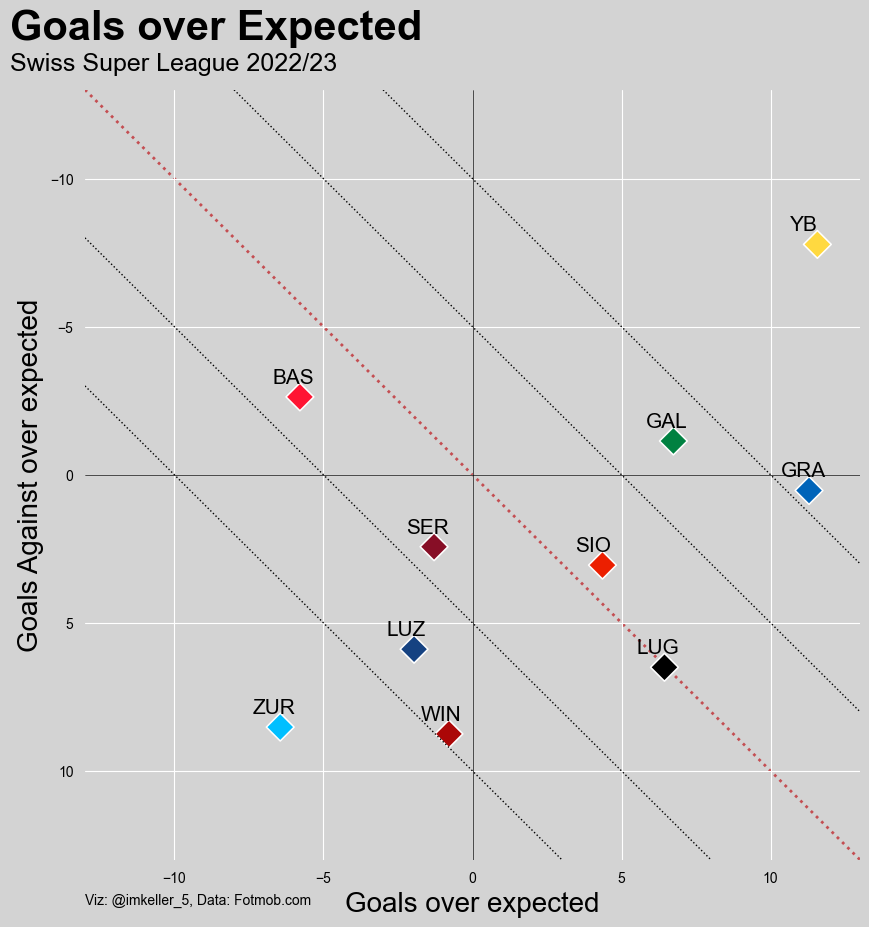

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)


sns.scatterplot(x=df_teams['goals_over_expected_sum'], y=df_teams['goals_against_over_expected_sum'],hue=df_teams['team_short'],palette=team_colors, s=200,legend=False,marker='D')
ax.set_xlabel('Goals over expected',fontsize=20, color=text_color)
ax.set_ylabel('Goals Against over expected',fontsize=20, color=text_color)
fig.text(0.05,0.93,'Goals over Expected', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.05,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)

ax.axvline(0, linewidth=0.5, color=text_color)
ax.axhline(0, linewidth=0.5, color=text_color)
ax.axline(xy1=(0, 0), slope=1, color='r', lw=2, ls='dotted', zorder=0)
ax.axline(xy1=(5, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(-5, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(10, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(-10, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)


ax.set_xlim(-13,13)
ax.set_ylim(-13,13)
ax.axes.invert_yaxis()

for a in df_teams['team_short']:
    ax.annotate(a, (df_teams.loc[df_teams['team_short'] == a,'goals_over_expected_sum'].values[0],df_teams.loc[df_teams['team_short'] == a,'goals_against_over_expected_sum'].values[0]), xytext=(-20,10), textcoords='offset points', fontsize=15,color=text_color)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

ax.annotate("Viz: @imkeller_5, Data: Fotmob.com", (-13, 14.5), annotation_clip=False, fontsize=10, color=text_color)
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.despine(left=True, bottom=True)
plt.show()

fig.savefig('figs/super_league_goals_over_expected_23_01_28.jpg',bbox_inches='tight')

## rolling xG and xGA difference

In [10]:
df_games['xg_diff'] = df_games['expected_goals_(xg)'] - df_games['expected_goals_against_(xga)']

In [11]:
df_rolling = pd.DataFrame()
for team in df_games['team'].unique():
    df_rolling['{}'.format(df_games.loc[df_games['team']==team,"team_short"].values[0])]= df_games.loc[df_games['team']==team, ['match_round','xg_diff']].set_index('match_round').rolling(5,min_periods=1).sum()['xg_diff']

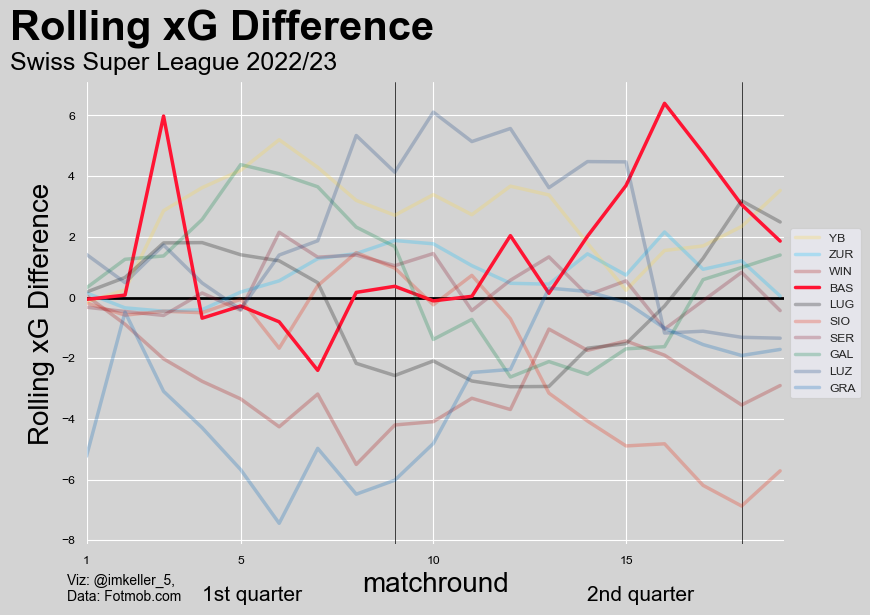

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
sns.set_palette("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("paper")

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
for team in df_games['team_short'].unique():
    if team in ['BAS']: 
        al = 1 
    else:
        al = 0.25
    sns.lineplot(x=df_rolling.index, y=df_rolling[team], label=team, color=team_colors[team],zorder=30, alpha=al, linewidth=2.5)

ax.axhline(0, linewidth=2,zorder=10,color=text_color)
ax.axvline(9, linewidth=0.5,zorder=5,color=text_color)
ax.axvline(18, linewidth=0.5,zorder=10,color=text_color)
ax.set_xlabel('matchround',fontsize=20, color=text_color)
ax.set_ylabel('Rolling xG Difference',fontsize=20, color=text_color)
fig.text(0.04,0.95,'Rolling xG Difference', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.04,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)
ax.annotate("Viz: @imkeller_5, \nData: Fotmob.com", (0.5,-10), annotation_clip=False, fontsize=10, color=text_color)
ax.annotate("1st quarter", (4, -10), annotation_clip=False, fontsize=15, color=text_color)
ax.annotate("2nd quarter", (14, -10), annotation_clip=False, fontsize=15, color=text_color)
#ax.annotate("3rd quarter", (19, -4.5), annotation_clip=False, fontsize=15, color=text_color)
ax.set_xticks([1, 5, 10, 15])
ax.set_xlim(1,19.1)
sns.despine(left=True, bottom=True)
ax.legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True)

fig.savefig('figs/super_league_rolling_xg_difference_23_01_28.jpg',bbox_inches='tight')

# Shotmaps

## Player Shotmaps

TODO:
- Goal & xG numbers and other infos on graphic 
- convex hull for most shots

In [13]:
df_shots_open_play = df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),:].copy()
df_shots_open_play.loc[df_shots_open_play['event_type']=='Goal','is_goal'] = 1
df_shots_open_play.loc[df_shots_open_play['event_type']!='Goal','is_goal'] = 0

['Jean Pierre Nsame', 'Hayao Kawabe', 'Cedric Itten', 'Emmanuel Latte Lath', 'Zan Celar', 'Filip Stojilkovic', 'Jeremy Guillemenot', 'Chadrac Akolo', 'Renat Dadashov', 'Giovanni Sio', 'Meschack Elia', 'Aiyegun Tosin', 'Matteo Di Giusto', 'Max Meyer', 'Bradley Fink', 'Renato Steffen', 'Mohamed Amoura', 'Andi Zeqiri', 'Mohamed Dräger', 'Miroslav Stevanovic']


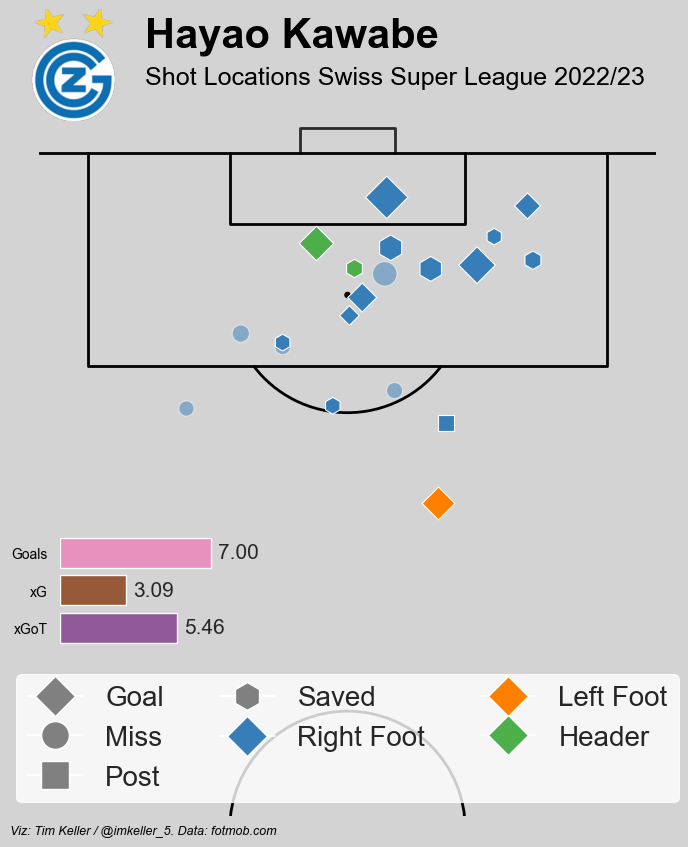

In [14]:
players = df_shots_open_play.loc[df_shots_open_play['event_type']=='Goal','player_name'].value_counts().head(20).index.tolist()
print(players)
player = players[1]

player_stats = df_shots_open_play.loc[df_shots_open_play['player_name']==player,['is_goal', 'expected_goals', 'expected_goals_on_target']]
player_stats_summed = player_stats.sum()

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

pitch = VerticalPitch('uefa',pad_bottom=-1, half=True, goal_type='box', goal_alpha=0.8, line_color=text_color, pad_left=-10, pad_right=-10)
fig, ax = pitch.draw(figsize=(9,7.5))
fig.set_facecolor(background)
ax.patch.set_alpha(0)


saved_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='h', ax=ax, zorder=15)

miss_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, alpha=0.5, c=CB_color_cycle[0],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, alpha=0.5, c=CB_color_cycle[1],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, alpha=0.5, c=CB_color_cycle[2],edgecolors=edge,marker='o', ax=ax, zorder=5)

post_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='s', ax=ax, zorder=10)

goals_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='D', ax=ax, zorder=20)

legend_elements = [
       lines.Line2D([0], [0], marker='D', color='w', label='Goal', markerfacecolor='grey', markersize=20),
       lines.Line2D([0], [0], marker='o', color='w', label='Miss', markerfacecolor='grey', markersize=20),
       lines.Line2D([0], [0], marker='s', color='w', label='Post', markerfacecolor='grey', markersize=20),
       lines.Line2D([0], [0], marker='h', color='w', label='Saved', markerfacecolor='grey', markersize=20),
       lines.Line2D([0], [0], marker='D', color='w', label='Right Foot', markerfacecolor=CB_color_cycle[0], markersize=20),
       lines.Line2D([0], [0], marker='D', color='w', label='Left Foot', markerfacecolor=CB_color_cycle[1], markersize=20),
       lines.Line2D([0], [0], marker='D', color='w', label='Header', markerfacecolor=CB_color_cycle[2], markersize=20)
       ]
legend = ax.legend(handles=legend_elements, loc='lower center', fontsize=10, prop={'size': 20}, ncol=3)
frame = legend.get_frame()
frame.set_color('white')

ax2 = fig.add_axes([0.12,0.95,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[df_shots.loc[df_shots['player_name']==player,'team_short'].unique()[0]]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

ax3 = fig.add_axes([0.18,0.25,0.6,0.15]) # badge
sns.set_style("white")
sns.set(font_scale=1)
sns.barplot(y=['Goals', 'xG', 'xGoT'], x=player_stats_summed, palette=CB_color_cycle[3:], ax=ax3)
ax3.set_xlim(0,25)
sns.despine(left=True, bottom=True)
ax3.xaxis.set_visible(False)
ax3.bar_label(ax3.containers[0], fmt='%.2f', padding=5, fontsize=15)
ax3.set_facecolor(background)
#ax3.patch.set_alpha(0)


fig.text(0.125, 0.0, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com",
        fontstyle="italic",fontsize=9,  color=text_color)


fig.text(0.275,1.05,player, fontsize=30, color=text_color, fontweight='bold')
fig.text(0.275,1,'Shot Locations Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)

plt.tight_layout()
plt.show()

fig.savefig('figs/{}_shotmap.jpg'.format(player).lower().replace(' ','_'),bbox_inches='tight')

## Team Shotmaps
- Binned Shotmaps with zones on the field
- smaller binned shotmaps for goals? (to show finishing zones)

## Expected Points Table

## Goalkeeper Stats

In [15]:
df_goalies = df_shots_open_play.groupby('keeper_shot_faced').sum().reset_index().rename(columns={'keeper_shot_faced':'keeper', 'is_goal':'goals'})[['keeper','expected_goals','expected_goals_on_target','goals']]
df_goalies = df_goalies.merge(df_shots_open_play.groupby('keeper_shot_faced').count().reset_index()[['keeper_shot_faced','shot_id']].rename(columns={'keeper_shot_faced':'keeper','shot_id':'shots_faced'}), on='keeper')

/var/folders/ts/3wmv3bq14n37zqx8km69cxtm0000gn/T/ipykernel_4954/3470076428.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_goalies = df_shots_open_play.groupby('keeper_shot_faced').sum().reset_index().rename(columns={'keeper_shot_faced':'keeper', 'is_goal':'goals'})[['keeper','expected_goals','expected_goals_on_target','goals']]


In [16]:
df_goalies['goals_saved_above_expected'] = df_goalies['expected_goals_on_target'] - df_goalies['goals']
df_goalies

,keeper,expected_goals,expected_goals_on_target,goals,shots_faced,goals_saved_above_expected
0,Ati-Zigi,20.618414,24.1260,19.0,202,5.1260
1,Brecher,16.847027,24.3982,25.0,189,-0.6018
2,Fayulu,13.742151,14.8211,17.0,133,-2.1789
3,Frick,19.446619,16.2014,19.0,263,-2.7986
4,Hammel,10.851997,9.5517,13.0,119,-3.4483
5,Hitz,19.074133,19.1370,18.0,197,1.1370
6,Kostadinovic,1.610031,2.0432,1.0,14,1.0432
7,Kuster,3.344440,2.7632,4.0,32,-1.2368
8,Lindner,23.199011,22.5189,28.0,233,-5.4811
9,Loretz,0.541300,0.5845,0.0,12,0.5845


In [17]:
df_goalies_ranking = df_goalies[df_goalies['shots_faced'] >= 50].sort_values('goals_saved_above_expected', ascending=False).reset_index(drop=True)

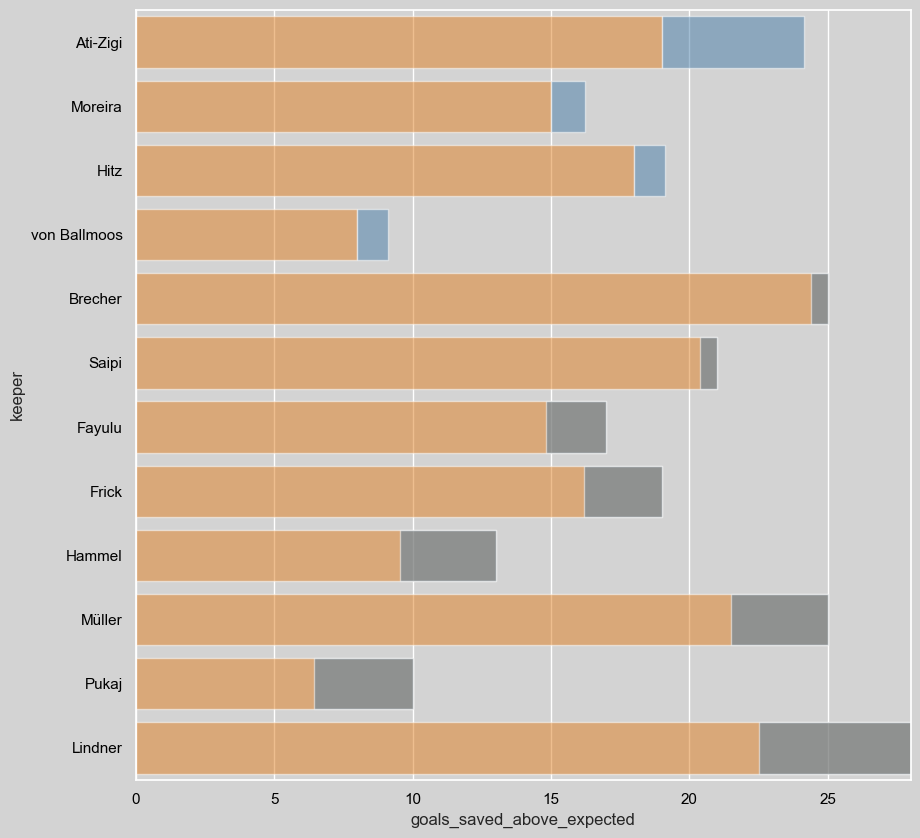

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)


fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

sns.barplot(y=df_goalies_ranking['keeper'],x=df_goalies_ranking['goals'],label='goals against',color=CB_color_cycle[1], alpha=0.5)
sns.barplot(y=df_goalies_ranking['keeper'],x=df_goalies_ranking['goals_saved_above_expected'],label='expected goals against on target',left=df_goalies_ranking['goals'], color=CB_color_cycle[0], alpha=0.5)

#ax.axvline(0, linewidth=2,color=text_color)
#ax.set_xlim(-2.5,2.5)

#ax.set_ylabel('Teams',fontsize=20, color=text_color)
#ax.set_xlabel('',fontsize=20)
#fig.text(-0.05,0.93,'Expected Goals Breakdown', fontsize=30, fontfamily=title_font, color=text_color, fontweight='bold')
#fig.text(-0.05,0.90,'Swiss Super League 2022/23', fontweight='regular',fontsize=18, fontfamily=title_font,color=text_color)
#ax.legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True)
#ax.annotate("Viz: @imkeller_5, Data: Fotmob.com", (-3.5,11), annotation_clip=False, fontsize=10, color=text_color)
#ax.annotate("expected goals against / game", (-2.5, 10.5), annotation_clip=False, fontsize=20, color=text_color)
#ax.annotate("expected goals / game", (0.25, 10.5), annotation_clip=False, fontsize=20, color=text_color)
plt.show()


## Player Graphics Table